In [126]:
import os
from os import listdir
from PIL import Image
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from keras.models import load_model
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Concatenate, Dropout, BatchNormalization
import pickle
import cv2
import librosa
from keras_facenet import FaceNet
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder




### Define face model

In [127]:
HaarCascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
face_model = FaceNet()

### Define speech model

In [128]:
max_length = 100
speech_model = load_model('speech_embedding_model.keras')

### Combination

In [129]:

# final_model = Sequential()

# # ce model prend comme entree la concatenation des embeddings
# final_model.add(Dense(64, activation='relu', input_shape=(640,))) # face net produice embedding of size 512 + 128 (speech embedding)
# final_model.add(Dropout(0.8))
# final_model.add(Dense(32, activation='relu'))
# final_model.add(Dropout(0.7))
# final_model.add(Dense(5, activation='softmax'))

# final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model = Sequential()

# Input layer
model.add(Dense(256, input_dim=640, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.83))

# Hidden layers
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.83))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.83))

# Output layer
# Adjust the units and activation function according to your prediction task
model.add(Dense(5, activation='softmax'))  # For classification


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# final_model.summary()

c:\Users\laktam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Creating pre-processing methods for image and audio data

#### Image

In [130]:
# cette method fait l'extraction de visage dans l'image (HaarCascade)
def get_face_from_image(path):
    gbr1 = cv2.imread(path)
    
    faces = HaarCascade.detectMultiScale(gbr1,1.1,4)
    
    if len(faces)>0:
        x1, y1, width, height = faces[0]         
    else:
        x1, y1, width, height = 1, 1, 10, 10
        
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    gbr = cv2.cvtColor(gbr1, cv2.COLOR_BGR2RGB)
    gbr = Image.fromarray(gbr)                  # conversion from OpenCV to PIL
    gbr_array = asarray(gbr)
    
    face = gbr_array[y1:y2, x1:x2]                        
    
    face = Image.fromarray(face)                       
    face = face.resize((160,160))
    face = asarray(face)
    
    # face = face.astype('float32')
    # mean, std = face.mean(), face.std()
    # face = (face - mean) / std
    
    face = expand_dims(face, axis=0)
    return face

#### Speech

In [131]:
# extraction des features du speech (mfcc)
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)# 13 = refers to the number of extracted features
    return mfcc.T  # Transpose to have time steps first

### Prepar trainning data

In [132]:
# loop over speech data set
# for each file in speech dataset
# get the name
# get the corespending image
# pass the image and the audio to the two models (prepar audio (mfcc, padding))
# create two lists (data, labels)
# append the concatenated version to data and the name to labels


# from sklearn.preprocessing import StandardScaler,MinMaxScaler
# scaler = StandardScaler()

# passer sur la dataset et generer les embeddings et les labels
def extract_embeddings_and_labels(speech_dataset, image_dataset):
    i = 0
    embeddings = []
    labels = []

    for file_name in os.listdir(speech_dataset):
        if file_name.endswith('.wav'):
            print(i)
            i = i+1
            file_path = os.path.join(speech_dataset, file_name)
            features = extract_features(file_path)
            #padding
            padded_features = pad_sequences([features], maxlen=max_length, padding='post', dtype='float32')
            speech_embedding = speech_model.predict(padded_features)
            # print("speech embedding " , speech_embedding)
            ## preparing face
            # getting image name from speech filename
            name = file_name.split('_')[0]
            image_path = os.path.join(image_dataset, name + ".jpg")
            # print("image path ", image_path)
            face = get_face_from_image(image_path)
            face_embedding = face_model.embeddings(face)
            # print("embedding of face " ,name ,  face_embedding)
            # concatenation

            # Normalize embeddings
            # face_embedding = scaler.fit_transform(face_embedding)
            # speech_embedding = scaler.fit_transform(speech_embedding)


            concatenated_embedding = np.concatenate((face_embedding[0], speech_embedding[0]))#, axis=1 axis was 0 !!!!!!!!!!!
            embeddings.append(concatenated_embedding)
            labels.append(name)
            # because model take a numpy array
            embeddings_array = np.array(embeddings)

    return embeddings_array, labels

In [133]:
# embeddings, labels = extract_embeddings_and_labels("speech_dataset", "image_dataset")

In [134]:
# # # save embeddings and labels
# # with open('embeddings.pkl', 'wb') as f:
# #     pickle.dump(embeddings, f)

# # because pickle doesnt save embeddings as numpy array
# np.save("embeddings.npy", embeddings)


# with open('labels.pkl', 'wb') as f:
#     pickle.dump(labels, f)

In [135]:
# load embeddins and labels
# # with open('old_embeddings/embeddings.pkl', 'rb') as f:
# #    embeddings = pickle.load(f)

embeddings = np.load("embeddings.npy")


with open('old_embeddings/labels.pkl', 'rb') as f:
    labels = pickle.load(f)

# normalize embeddings


train, test, labels_train, labels_test = train_test_split(
    embeddings, labels, test_size=0.3, random_state=12 , stratify=labels
)

In [136]:
#Encodding 
label_encoder = LabelEncoder()
encoded_labels_train = label_encoder.fit_transform(labels_train)

# encoded_labels_test = label_encoder.fit_transform(labels_test)
encoded_labels_test = label_encoder.transform(labels_test)

labels_tain_one_hot = to_categorical(encoded_labels_train)
labels_test_one_hot = to_categorical(encoded_labels_test)


In [137]:
print("Shape of train data:", train.shape)
print("Shape of labels:", labels_tain_one_hot.shape)
history = model.fit(train, labels_tain_one_hot, epochs=10, batch_size=32,validation_split=0.1)


Shape of train data: (1575, 640)
Shape of labels: (1575, 5)
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.2141 - loss: 3.6197 - val_accuracy: 0.7278 - val_loss: 1.2742
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3133 - loss: 2.4818 - val_accuracy: 0.9810 - val_loss: 0.9904
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3670 - loss: 2.1118 - val_accuracy: 0.9810 - val_loss: 0.7636
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4680 - loss: 1.5858 - val_accuracy: 0.9810 - val_loss: 0.5531
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4931 - loss: 1.4014 - val_accuracy: 0.9810 - val_loss: 0.3817
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5582 - loss: 1.1452 - val_accuracy: 0.9873 - val_loss: 0.2593
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5892 - loss: 1.0654 - val_accuracy: 0.9873 - val_loss: 0.1849
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accur

In [138]:
# test_array = np.array(test)

loss, accuracy = model.evaluate(test, labels_test_one_hot)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# normalisation + 0.5 0.5 dropout : Test Accuracy: 19.11%
# without normalisation + 0.5 0.5 dropout : Test Accuracy: 99.78%
# normalisation + no dropout : Test Accuracy: 19.11%

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0846 
Test Accuracy: 99.11%


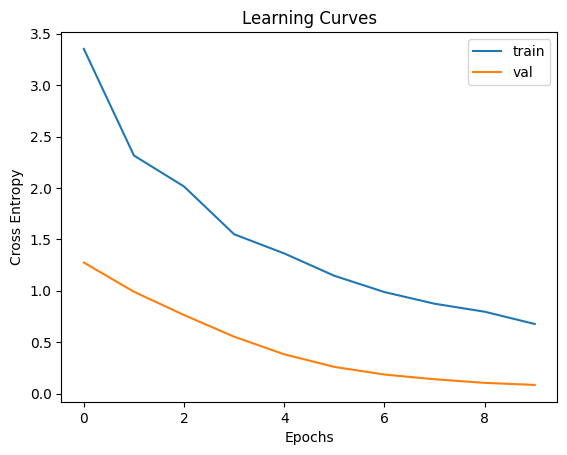

In [139]:
from matplotlib import pyplot
pyplot.title('Learning Curves')
pyplot.xlabel('Epochs')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [140]:
def generate_concatenated_embedding(image_path, voice_path):
    features = extract_features(voice_path)
    #padding
    padded_features = pad_sequences([features], maxlen=max_length, padding='post', dtype='float32')
    speech_embedding = speech_model.predict(padded_features)

    face = get_face_from_image(image_path)
    face_embedding = face_model.embeddings(face)
    # concatenation
    concatenated_embedding = np.concatenate((face_embedding[0], speech_embedding[0]))
    # returing a numpy array with one element to pass it directly to model
    return np.array([concatenated_embedding])

In [141]:
embedding = generate_concatenated_embedding('extra_test_files/gates.jpeg','speech_dataset/gates_0_03_1.wav')# 'extra_test_files/0_12_9.wav'
predictions = model.predict(embedding)
decoded_labels= label_encoder.inverse_transform(np.argmax(predictions, axis=1))
print(decoded_labels[0])
ps = predictions[0] * 100 
for p in ps:
    print(f'{p:.2f}%')
ps

##############


embedding = generate_concatenated_embedding('extra_test_files/trump.jpeg','speech_dataset/trump_2_05_36.wav')
predictions = model.predict(embedding)
decoded_labels= label_encoder.inverse_transform(np.argmax(predictions, axis=1))
print(decoded_labels[0])
ps = predictions[0] * 100 
for p in ps:
    print(f'{p:.2f}%')
ps
##########################
embedding = generate_concatenated_embedding('extra_test_files/sam2.jpg','D:/MQL/S2/ML/Projet Image, Audio/speech_recognition/test_data/sam_9_04_0.wav')
predictions = model.predict(embedding)
decoded_labels= label_encoder.inverse_transform(np.argmax(predictions, axis=1))
print(decoded_labels[0])
ps = predictions[0] * 100 
for p in ps:
    print(f'{p:.2f}%')
ps
###############

# unknown
embedding = generate_concatenated_embedding('extra_test_files/tim.jpeg','extra_test_files/0_12_9.wav')# 
predictions = model.predict(embedding)
decoded_labels= label_encoder.inverse_transform(np.argmax(predictions, axis=1))
print(decoded_labels[0])

# predictions = final_model.predict(test_array)
# # predictions = predictions * 100
ps = predictions[0] * 100 
for p in ps:
    print(f'{p:.2f}%')
ps



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
gates
94.63%
0.96%
0.55%
3.23%
0.63%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
trump
1.38%
0.68%
2.72%
1.93%
93.30%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
sam
2.69%
1.40%
0.95%
92.85%
2.10%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
mark
4.64%
56.87%
31.23%
3.28%
3.98%


array([ 4.6369996, 56.872185 , 31.230417 ,  3.277231 ,  3.9831724],
      dtype=float32)

In [142]:
def identify_person(predictions, threshold=0.9, unknown_label="unknown"):
    max_prob = max(predictions[0])
    print(max_prob)
    # max_index = np.argmax(predictions)
    decoded_labels= label_encoder.inverse_transform(np.argmax(predictions, axis=1))
   
    if max_prob >= threshold:
        # Person identified with high confidence
        return decoded_labels[0]
    else:
        # Confidence below threshold, person is unknown
        return unknown_label

In [143]:
embedding = generate_concatenated_embedding('extra_test_files/gates.jpeg','speech_dataset/gates_0_03_1.wav')# 'extra_test_files/0_12_9.wav'
predictions = model.predict(embedding)
print(identify_person(predictions))
##############
embedding = generate_concatenated_embedding('extra_test_files/trump.jpeg','speech_dataset/trump_2_05_36.wav')
predictions = model.predict(embedding)
print(identify_person(predictions))
##########################
embedding = generate_concatenated_embedding('extra_test_files/sam2.jpg','D:/MQL/S2/ML/Projet Image, Audio/speech_recognition/test_data/sam_9_04_0.wav')
predictions = model.predict(embedding)
print(identify_person(predictions))
###############

# unknown
embedding = generate_concatenated_embedding('extra_test_files/mkbhd.jpg','extra_test_files/0_12_9.wav')# 
predictions = model.predict(embedding)
print(identify_person(predictions))

embedding = generate_concatenated_embedding('extra_test_files/tim.jpeg','extra_test_files/0_12_9.wav')# 
predictions = model.predict(embedding)
print(identify_person(predictions))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.9463318
gates
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0.93295854
trump
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.9285465
sam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0.62373877
unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0.56872183
unknown


In [144]:
# save model
model.save('final_model.h5')
model.save('final_model.keras')


In [145]:
# Save the label encoder
import joblib
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']